# Intro
During the Boston Dragon Boat Festival of 2019, there are 4 different lanes and 3 different sets of boats.
Teams race a total of 3 times during quarterfinals/semifinals/finals. Using this data, can we determine if
there particular lanes that are better than others (most teams consistently doing worse in a particular lane)?
Are there particular sets of boats or specific boats that are advantageous since some are newer (most teams
consistently doing better)? Can we determine a representative time for each team to get an idea of how they
compare with each other correcting for these factors?

Data was obtained and reorganized based on: https://docs.google.com/spreadsheets/d/e/2PACX-1vR5avEH64BpkbvjiDU5Mpo-R--d6JELbh3eITSMjSCHLW2lZezcC3SoRXNFp2PxmA/pubhtml#

In [347]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [348]:
# Load Data
bostondb = pd.read_csv('Boston2019_Sunday_results.csv')

# Add column that specifies which set of boats was used for the race
bostondb['Boat'] = ((bostondb['Race']-1) % 3)+1

# Add column that specifies which round (quarterfinals/semifinals/finals) the races were
# Races 1-20 were quarterfinals, 21-39 were semifinals, and 40-58 were finals
round_conditions = [bostondb['Race'] < 21, (bostondb['Race'] > 20) & (bostondb['Race'] < 40), bostondb['Race'] > 39]
round_choices = ['Quarter', 'Semi', 'Finals']
bostondb['Round'] = np.select(round_conditions, round_choices, default='Other')

# Remove 0:00:00, 4:00:00, and 5:00:00 times since those were forfeited
bostondb = bostondb[(bostondb.Time != '00:00.000') & (bostondb.Time != '04:00.000') & (bostondb.Time != '05:00.000')]

# Remove outlier of 3:11.2 from Wellington Management Four Seas - Team 2, who dropped out after quarterfinals
bostondb = bostondb[bostondb.Team != 'Wellington Management Four Seas - Team 2']

# Add column that specifies which division based on semifinals seedings
division_conditions = [bostondb['Race'].isin([37, 38, 39]),
                       bostondb['Race'].isin([34, 35, 36]),
                       bostondb['Race'].isin([31, 32, 33]),
                       bostondb['Race'].isin([28, 29, 30]),
                       bostondb['Race'].isin([25, 26, 27]),
                       bostondb['Race'].isin([21, 22, 23, 24])]
division_choices = ['A', 'B', 'C', 'D', 'E', 'F']
bostondb['Division'] = np.select(division_conditions, division_choices, default='Other')

for iTeam in bostondb.Team.unique():
    temp = bostondb['Division'][(bostondb.Team == iTeam) & (bostondb.Round == 'Semi')].values
    bostondb.loc[(bostondb.Team == iTeam), 'Division'] = temp

# Check the data
print(bostondb.head())
print(bostondb.tail())

# Examine datatypes of entries
bostondb.dtypes

# Change the datatype of Team, Round, and Division to 'category'
bostondb['Team'] = bostondb['Team'].astype('category')
bostondb['Round'] = bostondb['Round'].astype('category')
bostondb['Division'] = bostondb['Division'].astype('category')

# Change the datatype of Time to datetime (need to add 00: for hours first)
bostondb['Time'] = pd.to_timedelta('00:' + bostondb['Time'].astype(str))

# Change order of dataframe
bostondb = bostondb[['Race', 'Team', 'Time', 'Place', 'Boat', 'Lane', 'Round', 'Division']]

   Race  Place                                      Team       Time  Lane  \
0     1      1                 Wellness Warriors Thunder  02:42.425     3   
1     1      2   Chinese American BioMedical Association  02:45.677     2   
3     2      1  Wellington Management Four Seas - Team 1  02:36.045     3   
4     2      2                              Dragon Divas  02:40.435     2   
5     2      3                  Bank of America Red Tide  02:48.472     1   

   Boat    Round Division  
0     1  Quarter        F  
1     1  Quarter        F  
3     2  Quarter        F  
4     2  Quarter        F  
5     2  Quarter        F  
     Race  Place                         Team       Time  Lane  Boat   Round  \
220    57      4       Metro Athletic Dragons  02:11.997     3     3  Finals   
221    58      1          CYPN Storm Instinct  01:59.191     3     1  Finals   
222    58      2  Boston One Dragon Boat Team  02:00.010     2     1  Finals   
223    58      3             Living Root Blue  02

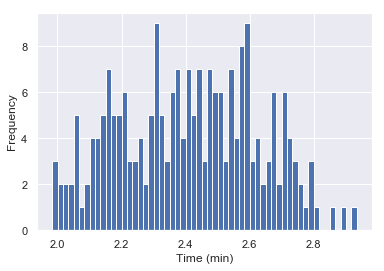

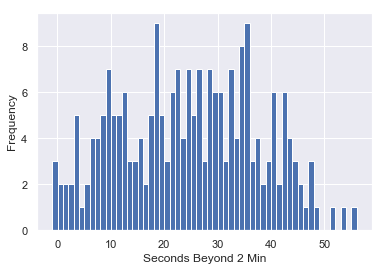

In [349]:
# Visualize the distribution of times
# Time in minutes
bostondb['Minutes'] = bostondb.Time / pd.Timedelta(minutes=1)
bostondb['Seconds'] = (bostondb.Time - pd.Timedelta(minutes=2)) / pd.Timedelta(seconds=1)

# Create a histogram to visualize distribution of times in minutes
bostondb.Minutes.plot(kind='hist', bins=np.arange(min(bostondb.Minutes), max(bostondb.Minutes) + 1/60, 1/60))
plt.xlabel('Time (min)')
plt.show() # Mostly a normal distribution, possibly trimodal

# Create a histogram to visualize distribution of times in seconds
bostondb.Seconds.plot(kind='hist', bins=np.arange(min(bostondb.Seconds), max(bostondb.Seconds) + 1, 1))
plt.xlabel('Seconds Beyond 2 Min')
plt.show()

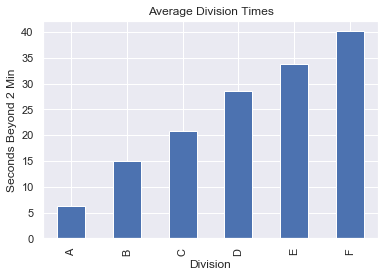

Boat
1    23.747587
2    25.817000
3    24.141554
Name: Seconds, dtype: float64


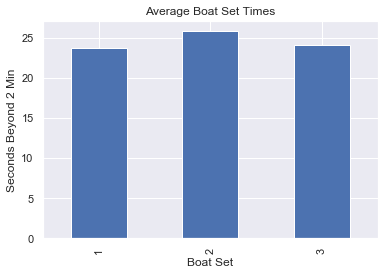

Lane
1    26.311214
2    25.048193
3    22.428070
4    24.391000
Name: Seconds, dtype: float64


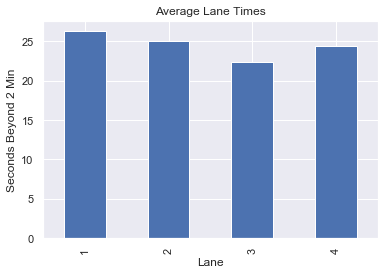

Boat  Lane
1     1       25.050667
      2       25.593450
      3       22.562050
      4       21.591000
2     1       27.606105
      2       26.722222
      3       21.916278
      4       27.145400
3     1       26.210526
      2       22.888316
      3       22.771895
      4       24.760647
Name: Seconds, dtype: float64


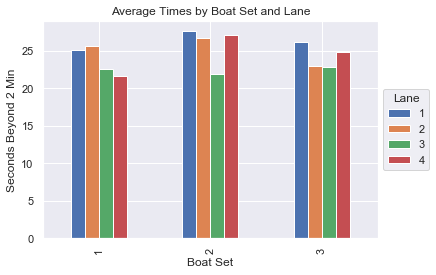

In [350]:
## Plot times according to division
division_means = bostondb.groupby(bostondb.Division).Seconds.mean()

# Create a bar plot
division_means.plot(kind="bar")
plt.ylabel('Seconds Beyond 2 Min')
plt.title('Average Division Times')
plt.show()

## Plot times according to set of boats
boat_means = bostondb.groupby(bostondb.Boat).Seconds.mean()
print(boat_means)

# Create a bar plot
boat_means.plot(kind="bar")
plt.xlabel('Boat Set')
plt.ylabel('Seconds Beyond 2 Min')
plt.title('Average Boat Set Times')
plt.show()

## Plot times according to lane
lane_means = bostondb.groupby(bostondb.Lane).Seconds.mean()
print(lane_means)

# Create a bar plot
lane_means.plot(kind="bar")
plt.xlabel('Lane')
plt.ylabel('Seconds Beyond 2 Min')
plt.title('Average Lane Times')
plt.show()

## Plot times according to both set of boats and lane
boatlane_means = bostondb.groupby([bostondb.Boat, bostondb.Lane]).Seconds.mean()
print(boatlane_means)

# Create a bar plot
boatlane_means.unstack().plot(kind="bar")
plt.xlabel('Boat Set')
plt.ylabel('Seconds Beyond 2 Min')
plt.title('Average Times by Boat Set and Lane')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Lane')
plt.show()

Boat
1    16.548479
2    18.884170
3    17.723170
Name: Seconds, dtype: float64


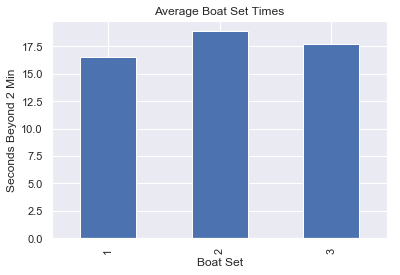

Lane
1    19.485250
2    17.498486
3    15.207324
4    18.773088
Name: Seconds, dtype: float64


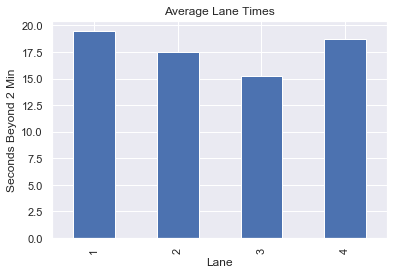

Boat  Lane
1     1       19.676583
      2       16.627583
      3       13.153333
      4       16.736417
2     1       19.847250
      2       18.784727
      3       15.637000
      4       21.770545
3     1       18.931917
      2       17.190333
      3       16.795833
      4       17.997455
Name: Seconds, dtype: float64


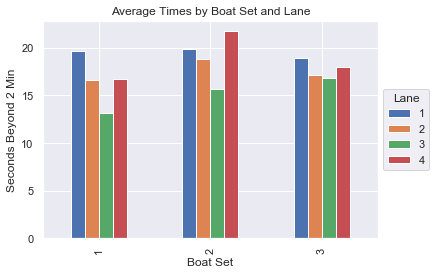

In [359]:
## What if you just consider Divisions A-D?
bostondbAD = bostondb[bostondb['Division'].isin(['A','B','C','D'])]

## Plot times according to set of boats
boat_means = bostondbAD.groupby(bostondbAD.Boat).Seconds.mean()
print(boat_means)

# Create a bar plot
boat_means.plot(kind="bar")
plt.xlabel('Boat Set')
plt.ylabel('Seconds Beyond 2 Min')
plt.title('Average Boat Set Times')
plt.show()

## Plot times according to lane
lane_means = bostondbAD.groupby(bostondbAD.Lane).Seconds.mean()
print(lane_means)

# Create a bar plot
lane_means.plot(kind="bar")
plt.xlabel('Lane')
plt.ylabel('Seconds Beyond 2 Min')
plt.title('Average Lane Times')
plt.show()

## Plot times according to both set of boats and lane
boatlane_means = bostondbAD.groupby([bostondbAD.Boat, bostondbAD.Lane]).Seconds.mean()
print(boatlane_means)

# Create a bar plot
boatlane_means.unstack().plot(kind="bar")
plt.xlabel('Boat Set')
plt.ylabel('Seconds Beyond 2 Min')
plt.title('Average Times by Boat Set and Lane')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Lane')
plt.show()

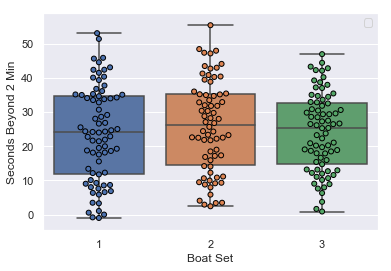

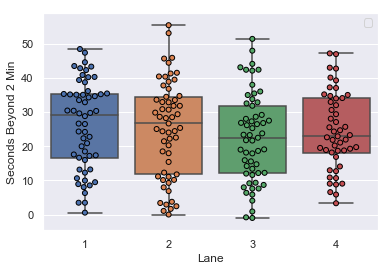

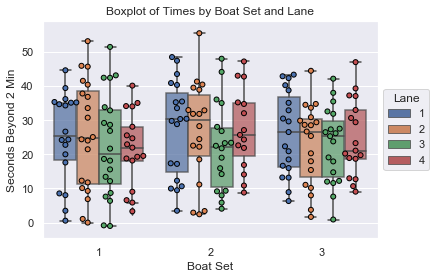

In [532]:
## What if you do boxplot and look at median times?
## Boxplot of times according to set of boats
sns.boxplot(x='Boat', y='Seconds', data=bostondb)
sns.swarmplot(x='Boat', y='Seconds', data=bostondb, dodge=True, edgecolor='black', linewidth=1)
plt.xlabel('Boat Set')
plt.ylabel('Seconds Beyond 2 Min')
plt.legend('')
plt.show()

## Boxplot of times according to lane
sns.boxplot(x='Lane', y='Seconds', data=bostondb)
sns.swarmplot(x='Lane', y='Seconds', data=bostondb, dodge=True, edgecolor='black', linewidth=1)
plt.xlabel('Lane')
plt.ylabel('Seconds Beyond 2 Min')
plt.legend('')
plt.show()

## Boxplot of times according to both set of boats and lane
ax = sns.boxplot(x='Boat', y='Seconds', data=bostondb, hue='Lane', boxprops=dict(alpha=0.75))
sns.swarmplot(x='Boat', y='Seconds', data=bostondb, hue='Lane', dodge=True, edgecolor='black', linewidth=1)
handles, labels = ax.get_legend_handles_labels()
plt.xlabel('Boat Set')
plt.ylabel('Seconds Beyond 2 Min')
plt.title('Boxplot of Times by Boat Set and Lane')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Lane', handles=handles[:4], labels=labels[:4])
plt.show()

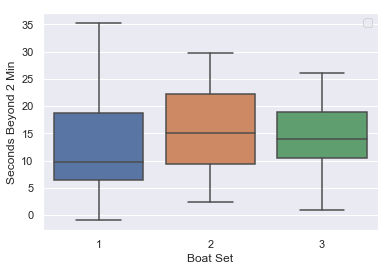

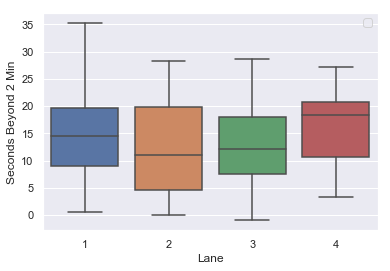

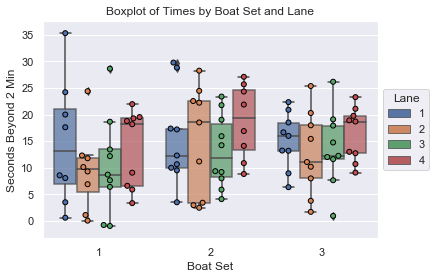

In [529]:
## What if you do median time considering just Divisions A-C?
## Boxplot of times according to set of boats
sns.boxplot(x='Boat', y='Seconds', data=bostondbAC)
sns.swarmplot(x='Boat', y='Seconds', data=bostondbAC, dodge=True, edgecolor='black', linewidth=1)
plt.xlabel('Boat Set')
plt.ylabel('Seconds Beyond 2 Min')
plt.legend('')
plt.show()

## Boxplot of times according to lane
sns.boxplot(x='Lane', y='Seconds', data=bostondbAC)
sns.swarmplot(x='Lane', y='Seconds', data=bostondbAC, dodge=True, edgecolor='black', linewidth=1)
plt.xlabel('Lane')
plt.ylabel('Seconds Beyond 2 Min')
plt.legend('')
plt.show()

## Boxplot of times according to both set of boats and lane
ax = sns.boxplot(x='Boat', y='Seconds', data=bostondbAC, hue='Lane', boxprops=dict(alpha=0.75))
sns.swarmplot(x='Boat', y='Seconds', data=bostondbAC, hue='Lane', dodge=True, edgecolor='black', linewidth=1)
handles, labels = ax.get_legend_handles_labels()
plt.xlabel('Boat Set')
plt.ylabel('Seconds Beyond 2 Min')
plt.title('Boxplot of Times by Boat Set and Lane')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Lane', handles=handles[:4], labels=labels[:4])
plt.savefig('Times by Boat and Lane.svg', format='svg')
plt.show()

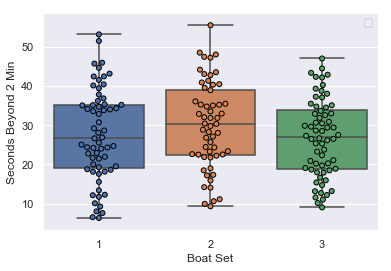

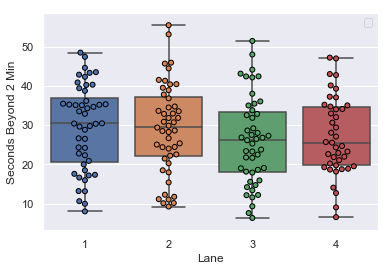

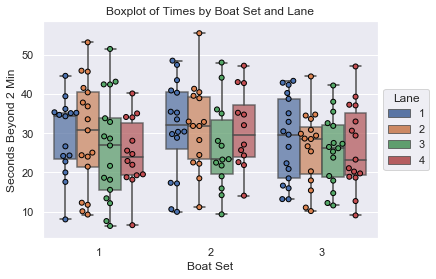

In [533]:
## What if you do median time considering just non-Division A?
bostondbnonA = bostondb[bostondb['Division'] != 'A']
## Boxplot of times according to set of boats
sns.boxplot(x='Boat', y='Seconds', data=bostondbnonA)
sns.swarmplot(x='Boat', y='Seconds', data=bostondbnonA, dodge=True, edgecolor='black', linewidth=1)
plt.xlabel('Boat Set')
plt.ylabel('Seconds Beyond 2 Min')
plt.legend('')
plt.show()

## Boxplot of times according to lane
sns.boxplot(x='Lane', y='Seconds', data=bostondbnonA)
sns.swarmplot(x='Lane', y='Seconds', data=bostondbnonA, dodge=True, edgecolor='black', linewidth=1)
plt.xlabel('Lane')
plt.ylabel('Seconds Beyond 2 Min')
plt.legend('')
plt.show()

## Boxplot of times according to both set of boats and lane
ax = sns.boxplot(x='Boat', y='Seconds', data=bostondbnonA, hue='Lane', boxprops=dict(alpha=0.75))
sns.swarmplot(x='Boat', y='Seconds', data=bostondbnonA, hue='Lane', dodge=True, edgecolor='black', linewidth=1)
handles, labels = ax.get_legend_handles_labels()
plt.xlabel('Boat Set')
plt.ylabel('Seconds Beyond 2 Min')
plt.title('Boxplot of Times by Boat Set and Lane')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Lane', handles=handles[:4], labels=labels[:4])
plt.savefig('Times by Boat and Lane.svg', format='svg')
plt.show()

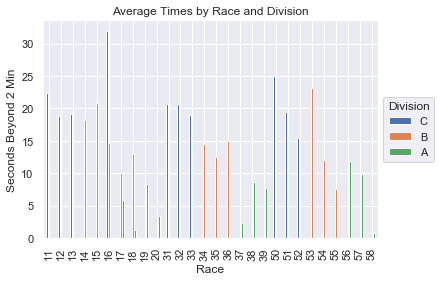

In [498]:
## Plot times according to race for each division (only considering divisions A-C for easier visualization)
bostondbAC = bostondb[bostondb['Division'].isin(['A','B','C'])]
racedivision_means = bostondbAC.groupby([bostondbAC.Race, bostondbAC.Division]).Seconds.mean()

# Create a bar plot
racedivision_means.unstack().plot(kind="bar")
plt.xlabel('Race')
plt.ylabel('Seconds Beyond 2 Min')
plt.title('Average Times by Race and Division')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Division')
plt.show()

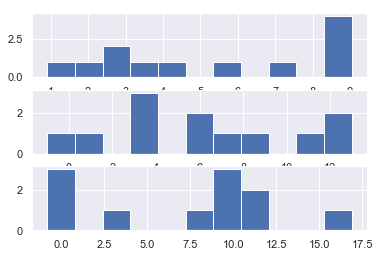

In [501]:
# Histogram of Distribution of Division A Times
bostondbA = bostondb[bostondb.Division == 'A']
fig, ax = plt.subplots(3, 1)
temp=bostondbA['Seconds'][bostondbA.Round=='Quarter']
ax[0].hist(bostondbA['Seconds'][bostondbA.Round=='Quarter'], bins=11)
ax[1].hist(bostondbA['Seconds'][bostondbA.Round=='Semi'], bins=11)
ax[2].hist(bostondbA['Seconds'][bostondbA.Round=='Finals'], bins=11)
plt.show()

In [415]:
# Sorted times for quarterfinals
bostondb[(bostondb.Division=='A') & (bostondb.Round=="Quarter")].sort_values(by=['Time'])

,Race,Team,Time,Place,Boat,Lane,Round,Division,Minutes,Seconds
64,18,Wolfpack Racing Club,00:02:00.908000,1,3,3,Quarter,A,2.015133,0.908
65,18,Living Root Blue,00:02:01.667000,2,3,2,Quarter,A,2.027783,1.667
72,20,CYPN Storm Instinct,00:02:02.438000,1,2,2,Quarter,A,2.040633,2.438
60,17,Boston One Dragon Boat Team,00:02:02.924000,1,2,2,Quarter,A,2.048733,2.924
73,20,Dragonheart VT - Dragonflyers,00:02:03.475000,2,2,1,Quarter,A,2.057917,3.475
74,20,ONE Racing,00:02:04.074000,3,2,3,Quarter,A,2.067900,4.074
61,17,CYPN Storm Valor,00:02:05.856000,2,2,3,Quarter,A,2.097600,5.856
68,19,Harvard Engine 9,00:02:06.878000,1,1,2,Quarter,A,2.114633,6.878
69,19,Trapology Boston,00:02:08.547000,2,1,1,Quarter,A,2.142450,8.547
70,19,Metro Athletic Dragons,00:02:08.681000,3,1,3,Quarter,A,2.144683,8.681


In [413]:
# Sorted times for semifinals
bostondb[(bostondb.Division=='A') & (bostondb.Round=="Semi")].sort_values(by=['Time'])

,Race,Team,Time,Place,Boat,Lane,Round,Division,Minutes,Seconds
138,37,Boston One Dragon Boat Team,00:01:59.013000,1,1,3,Semi,A,1.983550,-0.987
139,37,CYPN Storm Instinct,00:02:01.075000,2,1,2,Semi,A,2.017917,1.075
142,38,Living Root Blue,00:02:03.388000,1,2,2,Semi,A,2.056467,3.388
140,37,Trapology Boston,00:02:03.477000,3,1,1,Semi,A,2.057950,3.477
146,39,Wolfpack Racing Club,00:02:03.745000,1,3,2,Semi,A,2.062417,3.745
141,37,Metro Athletic Dragons,00:02:05.868000,4,1,4,Semi,A,2.097800,5.868
147,39,CYPN Storm Valor,00:02:06.314000,2,3,1,Semi,A,2.105233,6.314
148,39,ONE Racing,00:02:07.623000,3,3,3,Semi,A,2.127050,7.623
143,38,Dragonheart VT - Dragonflyers,00:02:07.976000,2,2,3,Semi,A,2.132933,7.976
144,38,Jiao Tong University Alumni - MicroPort,00:02:10.850000,3,2,4,Semi,A,2.180833,10.850


In [496]:
# Sorted times for finals
bostondb[(bostondb.Division=='A') & (bostondb.Round=="Finals")].sort_values(by=['Time'])

,Race,Team,Time,Place,Boat,Lane,Round,Division,Minutes,Seconds
221,58,CYPN Storm Instinct,00:01:59.191000,1,1,3,Finals,A,1.986517,-0.809
222,58,Boston One Dragon Boat Team,00:02:00.010000,2,1,2,Finals,A,2.000167,0.010
223,58,Living Root Blue,00:02:00.565000,3,1,1,Finals,A,2.009417,0.565
224,58,Trapology Boston,00:02:03.313000,4,1,4,Finals,A,2.055217,3.313
217,57,Wolfpack Racing Club,00:02:07.969000,1,3,2,Finals,A,2.132817,7.969
218,57,CYPN Storm Valor,00:02:08.922000,2,3,1,Finals,A,2.148700,8.922
213,56,Jiao Tong University Alumni - MicroPort,00:02:09.166000,1,2,3,Finals,A,2.152767,9.166
214,56,Harvard Engine 9,00:02:09.482000,2,2,1,Finals,A,2.158033,9.482
219,57,ONE Racing,00:02:10.681000,3,3,4,Finals,A,2.178017,10.681
220,57,Metro Athletic Dragons,00:02:11.997000,4,3,3,Finals,A,2.199950,11.997


# Tables of Times by Teams

In [497]:
# Top 10 Teams Times
topteams = bostondb[(bostondb.Division=='A') & (bostondb.Round=="Finals")].sort_values(by=['Time'])['Team']
topteamtimes = bostondb[bostondb['Team']==topteams.iloc[0]]
for i in range(1,11):
    temp = bostondb[bostondb['Team']==topteams.iloc[i]]
    topteamtimes = topteamtimes.append(temp)
topteamtimes

,Race,Team,Time,Place,Boat,Lane,Round,Division,Minutes,Seconds
72,20,CYPN Storm Instinct,00:02:02.438000,1,2,2,Quarter,A,2.040633,2.438
139,37,CYPN Storm Instinct,00:02:01.075000,2,1,2,Semi,A,2.017917,1.075
221,58,CYPN Storm Instinct,00:01:59.191000,1,1,3,Finals,A,1.986517,-0.809
60,17,Boston One Dragon Boat Team,00:02:02.924000,1,2,2,Quarter,A,2.048733,2.924
138,37,Boston One Dragon Boat Team,00:01:59.013000,1,1,3,Semi,A,1.983550,-0.987
222,58,Boston One Dragon Boat Team,00:02:00.010000,2,1,2,Finals,A,2.000167,0.010
65,18,Living Root Blue,00:02:01.667000,2,3,2,Quarter,A,2.027783,1.667
142,38,Living Root Blue,00:02:03.388000,1,2,2,Semi,A,2.056467,3.388
223,58,Living Root Blue,00:02:00.565000,3,1,1,Finals,A,2.009417,0.565
69,19,Trapology Boston,00:02:08.547000,2,1,1,Quarter,A,2.142450,8.547


In [505]:
bostondb[(bostondb.Round=="Finals")]

,Race,Team,Time,Place,Boat,Lane,Round,Division,Minutes,Seconds
150,40,Wellness Warriors Fire,00:02:43.121000,1,1,3,Finals,F,2.718683,43.121
151,40,Springfield Dragon Rays,00:02:53.129000,2,1,2,Finals,F,2.885483,53.129
153,41,Wellness Warriors Thunder,00:02:43.016000,1,2,4,Finals,F,2.716933,43.016
154,41,Chinese American BioMedical Association,00:02:43.499000,2,2,1,Finals,F,2.724983,43.499
155,41,Bank of America Red Tide,00:02:55.457000,3,2,2,Finals,F,2.924283,55.457
157,42,Johnson & Johnson Ducklings - Team 2,00:02:28.627000,1,3,2,Finals,F,2.477117,28.627
158,42,Dragon Divas,00:02:32.976000,2,3,4,Finals,F,2.549600,32.976
159,42,The Boat for Kids Who don't Paddle Good,00:02:42.146000,3,3,3,Finals,F,2.702433,42.146
160,42,CSOFT International,00:02:43.330000,4,3,1,Finals,F,2.722167,43.330
161,43,JP Morgan & Chase,00:02:32.862000,1,1,3,Finals,F,2.547700,32.862
